In [62]:
%reset -f

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

# Load each
datasets = {}
for hour in range(24):
    df = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

    datasets[hour] = deseasonalize(df, "both")

regex_choice = "^(sun_|wind_|temp_)"
pca_percent = 0.7

y_train, y_test, y_train_deseason, y_test_deseason, y_train_season, y_test_season, \
exog_variables_train, scalers, exog_variables_train_stand, exog_variables_test, \
exog_variables_test_stand, pca_train, pca_test = split_data_into_series(datasets, pca_percent, regex_choice)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\peter\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Hour 0 done
Hour 1 done
Hour 2 done
Hour 3 done
Hour 4 done
Hour 5 done
Hour 6 done
Hour 7 done
Hour 8 done
Hour 9 done
Hour 10 done
Hour 11 done
Hour 12 done
Hour 13 done
Hour 14 done
Hour 15 done
Hour 16 done
Hour 17 done
[ 7.09956533e-01  3.22655611e+03  5.21545562e+00 -1.11606228e-01]
Hour 18 done
Hour 19 done
Hour 20 done
Hour 21 done
Hour 22 done
Hour 23 done
SMAPE baseline (24 lags) out of sample prediction: [[298.90944381]
 [ 52.64479243]
 [ 71.28906454]]


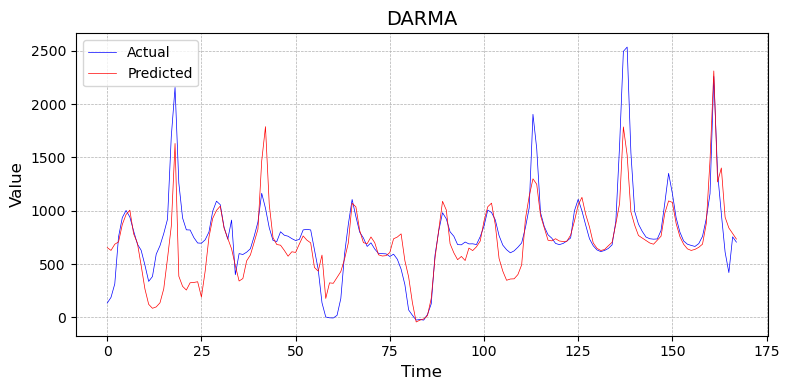

In [63]:
predictions_dict = {}

for hour in range(24):
    darma_mle_est = MLE_DARMA(y_train_deseason[hour])

    if hour == 18:
        print(darma_mle_est)
    

    darma_forecast = DARMA_forecast_array(darma_mle_est, y_test_deseason[hour].flatten())

    predictions_dict[hour] = darma_forecast.reshape(-1,1) + y_test_season[hour]

    print(f"Hour {hour} done")


combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)


model_1 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_1 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_1}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_1, "DARMA")

Hour 0 done
Hour 1 done
Hour 2 done


c:\Users\peter\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Hour 3 done
Hour 4 done
Hour 5 done
Hour 6 done
Hour 7 done
Hour 8 done
Hour 9 done
Hour 10 done
Hour 11 done
Hour 12 done
Hour 13 done
Hour 14 done
Hour 15 done
Hour 16 done
Hour 17 done
Hour 18 done
Hour 19 done
Hour 20 done
Hour 21 done
Hour 22 done
Hour 23 done
SMAPE baseline (24 lags) out of sample prediction: [[554.0950671 ]
 [ 53.2150792 ]
 [ 78.07557427]]


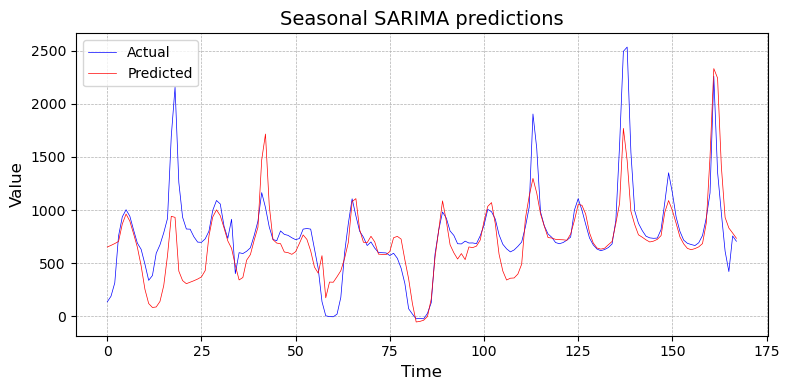

In [64]:
predictions_dict = {}

for hour in range(24):
    darma_mle_est = MLE_DARMAX(y_train_deseason[hour], pca_train[hour])

    darma_forecast = DARMAX_forecast_array(darma_mle_est, y_test_deseason[hour].flatten(), pca_test[hour])

    predictions_dict[hour] = darma_forecast.reshape(-1,1) + y_test_season[hour]

    print(f"Hour {hour} done")


combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)


model_2 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_2 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_2}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_2, "Seasonal SARIMA predictions")

In [65]:
# Combine all combined_predictions_model into one dataframe
combined_predictions_df = pd.DataFrame({
    'DARMA': combined_predictions_model_1.flatten(),
    'DARMAX': combined_predictions_model_2.flatten()
})

# Save the dataframe to a CSV file
combined_predictions_df.to_csv('combined_predictions_darma.csv', index=False)

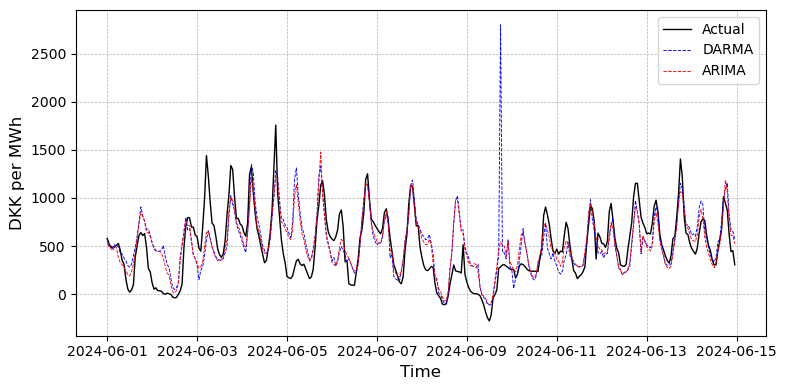

In [66]:
# Load combined_predictions.csv
combined_predictions_sarima = pd.read_csv("combined_predictions.csv")

combined_predictions_arma = combined_predictions_sarima["Model_3"]

dataset_date = [datasets[hour]['DATE'] for hour in range(24)]

datasets_dates = []

n_days = min(len(datasets[hour]) for hour in range(24))

combined_predictions = []

for day in range(n_days):
    for hour in range(24):
        datasets_dates.append(dataset_date[hour][day])

time = np.array(datasets_dates[-14712:])

df = pd.DataFrame({
    'Time': time,
    'DARMA': combined_predictions_model_1.flatten(),
    'ARIMA': combined_predictions_arma,
    'Actual': combined_test.flatten()
})

df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

# If date is 2023-01-01 and next 7 days plot
df = df.loc['2024-06-01':'2024-06-14']

plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Actual'], label='Actual',  color='black', linewidth=1)
plt.plot(df.index, df['DARMA'], label='DARMA',  color='blue', linewidth=0.65, linestyle='--')
plt.plot(df.index, df['ARIMA'], label='ARIMA',  color='red', linewidth=0.65, linestyle='--')

plt.xlabel('Time', fontsize=12)
plt.ylabel('DKK per MWh', fontsize=12)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


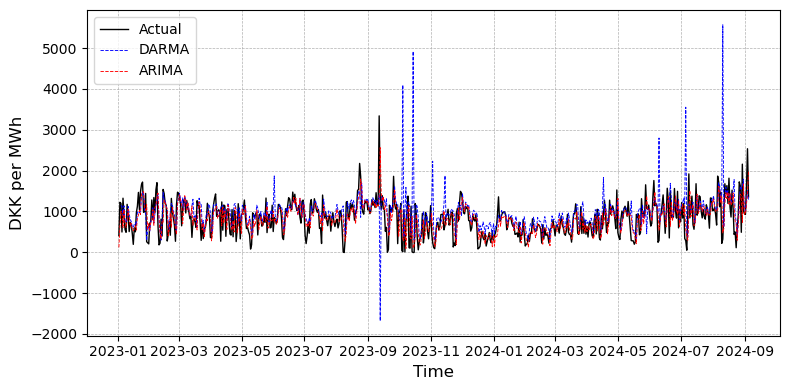

In [67]:
# Load combined_predictions.csv
combined_predictions_sarima = pd.read_csv("combined_predictions.csv")

combined_predictions_arma = combined_predictions_sarima["Model_3"]

dataset_date = [datasets[hour]['DATE'] for hour in range(24)]

datasets_dates = []

n_days = min(len(datasets[hour]) for hour in range(24))

combined_predictions = []

for day in range(n_days):
    for hour in range(24):
        datasets_dates.append(dataset_date[hour][day])

time = np.array(datasets_dates[-14712:])

df = pd.DataFrame({
    'Time': time,
    'DARMA': combined_predictions_model_1.flatten(),
    'ARIMA': combined_predictions_arma,
    'Actual': combined_test.flatten()
})
# 
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

# If date is 2023-01-01 and next 7 days plot
df = df.loc['2023-01-01':'2024-11-14']

# Subset to only include hour 1
df = df[df.index.hour == 18]

plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Actual'], label='Actual', color='black', linewidth=1)
plt.plot(df.index, df['DARMA'], label='DARMA', color='blue', linewidth=0.65, linestyle='--')
plt.plot(df.index, df['ARIMA'], label='ARIMA', color='red', linewidth=0.65, linestyle='--')

plt.xlabel('Time', fontsize=12)
plt.ylabel('DKK per MWh', fontsize=12)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()
